<center>

# Групповой проект
</center>

Цель - создание модели оценки справедливой стоимости квартир в Екатеринбурге.

## Шаг 5: создание новых признаков

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 4)

In [3]:
df = pd.read_excel('output2.xlsx')
df.head()

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,district,underground,owner
0,1,31,30.60,3673800,2023,14.0,7.0,Чкаловский,Ботаническая,False
1,25,31,35.80,5284000,2023,12.0,12.0,Ленинский,Чкаловская,False
2,14,25,37.99,4835128,2022,16.0,11.0,Октябрьский,Ботаническая,False
3,2,19,32.50,4106000,2025,10.0,10.0,Орджоникидзевский,Машиностроителей,False
4,14,16,42.00,4158074,2022,8.0,21.0,Орджоникидзевский,Проспект Космонавтов,False


Во-первых нужно закодировать категориальные признаки.

In [4]:
df['owner'] = df['owner'].replace(False, 0)
df['owner'] = df['owner'].replace(True, 1)

In [5]:
df = pd.get_dummies(df, columns=['district', 'underground'])

Теперь попробуем создать новые признаки:

- Является ли этаж первым?
- Является ли этаж последним?

In [6]:
df['is_first_floor'] = (df['floor'] == 1).astype(int)
df['is_last_floor'] = (df['floor'] == df['floors_count']).astype(int)

- Дом построен или нет?

In [7]:
df['is_constructed'] = (df['year_of_construction'] <= 2023).astype(int)

- Какая доля жилой площади от общей?
- Какая доля площади кухни от общей?

In [8]:
df['living_share'] = df['kitchen_meters'] / df['total_meters']
df['kitchen_share'] = df['living_meters'] / df['total_meters']

In [9]:
df.head()

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,owner,district_Автовокзал,district_Верх-Исетский,...,underground_Площадь 1905 года,underground_Проспект Космонавтов,underground_Уралмаш,underground_Уральская,underground_Чкаловская,is_first_floor,is_last_floor,is_constructed,living_share,kitchen_share
0,1,31,30.60,3673800,2023,14.0,7.0,0,0,0,...,0,0,0,0,0,1,0,1,0.228758,0.457516
1,25,31,35.80,5284000,2023,12.0,12.0,0,0,0,...,0,0,0,0,1,0,0,1,0.335196,0.335196
2,14,25,37.99,4835128,2022,16.0,11.0,0,0,0,...,0,0,0,0,0,0,0,1,0.289550,0.421163
3,2,19,32.50,4106000,2025,10.0,10.0,0,0,0,...,0,0,0,0,0,0,0,0,0.307692,0.307692
4,14,16,42.00,4158074,2022,8.0,21.0,0,0,0,...,0,1,0,0,0,0,0,1,0.500000,0.190476


## Шаг 6: гипотезы

### Гипотеза 1 ###

Квартиры, расположенные возле метро, имеют бóльшую этажность, чем квартиры в удалении от метро.

$$
\begin{aligned}
& H_0: \mu_{metro} = \mu_{without} \\
& H_1: \mu_{metro} > \mu_{without}
\end{aligned}
$$

Разобьем данные на 2 выборки.

In [10]:
df_m = df[df['underground_Нет метро'] == 0]
df_w = df[df['underground_Нет метро'] == 1]

Для выбора критерия проверки гипотезы сначала посмотрим на распределения выборок.

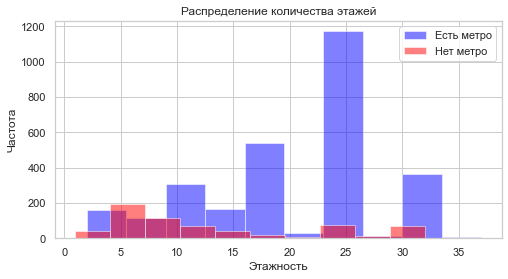

In [11]:
plt.hist(df_m['floors_count'], bins=10, color='blue', alpha=0.5, label='Есть метро')

plt.hist(df_w['floors_count'], bins=10, color='red', alpha=0.5, label='Нет метро')

plt.xlabel('Этажность')
plt.ylabel('Частота')
plt.title('Распределение количества этажей')
plt.legend()

plt.show()

На нормальное не похоже, будем использовать, непараметрический тест.

In [12]:
_, p_value = sts.mannwhitneyu(df_m['floors_count'], df_w['floors_count'], alternative='greater')

print("p-value:", round(p_value, 3))

p-value: 0.0


Отвергаем нулевую гипотезу. Квартиры, расположенные возле метро, действительно имеют бóльшую этажность, чем квартиры в удалении от метро.

### Гипотеза 2 ###

Новые квартиры в домах, построенных после распада СССР, стоят дороже старых.

$$
\begin{aligned}
& H_0: \mu_{new} = \mu_{old} \\
& H_1: \mu_{new} > \mu_{old}
\end{aligned}
$$

Разобьем данные на 2 выборки.

In [13]:
df_n = df[df['year_of_construction'] > 1991]
df_o = df[df['year_of_construction'] <= 1991]

Для выбора критерия проверки гипотезы снова нужно посмотреть на распределения выборок.

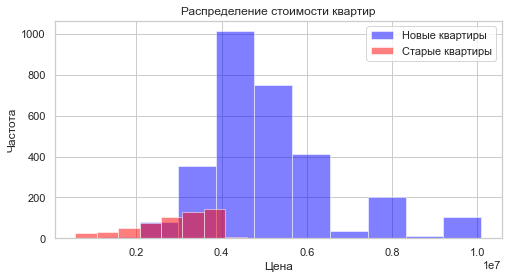

In [14]:
plt.hist(df_n['price'], bins=10, color='blue', alpha=0.5, label='Новые квартиры')

plt.hist(df_o['price'], bins=10, color='red', alpha=0.5, label='Старые квартиры')

plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение стоимости квартир')
plt.legend()

plt.show()

Нормальное распределение тут тоже не наблюдается. Снова используем u-тест.

In [15]:
_, p_value = sts.mannwhitneyu(df_n['price'], df_o['price'], alternative='greater')

print("p-value:", round(p_value, 3))

p-value: 0.0


Отвергаем нулевую гипотезу. Новые действительно квартиры дороже старых, хотя в Москве вряд ли бы была схожая ситуация.

### Гипотеза 3 ###

Хочется понять, почему результаты второй гипотезы оказались именно такими. Может старые дома расположены в удалении от центральных улиц и метро?

Гипотеза: квартиры возле метро построены позднее, чем квартиры в отдалении от него.

$$
\begin{aligned}
& H_0: \mu_{metro} = \mu_{without} \\
& H_1: \mu_{metro} > \mu_{without} 
\end{aligned}
$$

Снова смотрим на распределение.

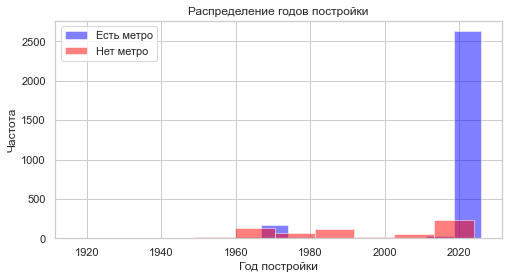

In [16]:
plt.hist(df_m['year_of_construction'], bins=10, color='blue', alpha=0.5, label='Есть метро')

plt.hist(df_w['year_of_construction'], bins=10, color='red', alpha=0.5, label='Нет метро')

plt.xlabel('Год постройки')
plt.ylabel('Частота')
plt.title('Распределение годов постройки')
plt.legend()

plt.show()

Нормальное распределение и не близко. Используем u-тест.

In [17]:
_, p_value = sts.mannwhitneyu(df_m['year_of_construction'], df_w['year_of_construction'], alternative='greater')

print("p-value:", round(p_value, 3))

p-value: 0.0


Отвергаем нулевую гипотезу. Похоже, изначально метро в Екатеринбурге решили строить в чистом поле.

### Гипотеза 4 ###

Интересно посмотреть, есть ли влияние того, находится ли квартира на первом этаже, на цену.

$$
\begin{aligned}
& H_0: \mu_{first} = \mu_{other} \\
& H_1: \mu_{first} \neq \mu_{other}
\end{aligned}
$$

В который раз разобьем данные на 2 выборки.

In [18]:
df_f = df[df['is_first_floor'] == 1]
df_nf = df[df['is_first_floor'] == 0]

Смотрим на распределения в выборках.

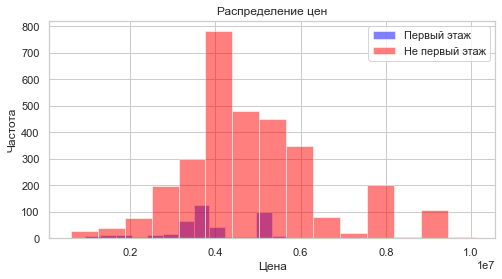

In [19]:
plt.hist(df_f['price'], bins=15, color='blue', alpha=0.5, label='Первый этаж')

plt.hist(df_nf['price'], bins=15, color='red', alpha=0.5, label='Не первый этаж')

plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение цен')
plt.legend()

plt.show()

Воспользуемся u-тестом.

In [20]:
_, p_value = sts.mannwhitneyu(df_f['price'], df_nf['price'], alternative='two-sided')

print("p-value:", round(p_value, 3))

p-value: 0.0


Отвергаем нулевую гипотезу. Цены квартир на первом этаже отличаются от цен на других этажах.

### Гипотеза 5 ###

При выборе квартиры важна планировка, например, доля кухни от общей площади. Поставим гипотезу, что в современных домах в квартирах доля кухни от общей площади стала меньше.

$$
\begin{aligned}
& H_0: \mu_{new} = \mu_{old} \\
& H_1: \mu_{new} < \mu_{old}
\end{aligned}
$$

Смотрим на распределения.

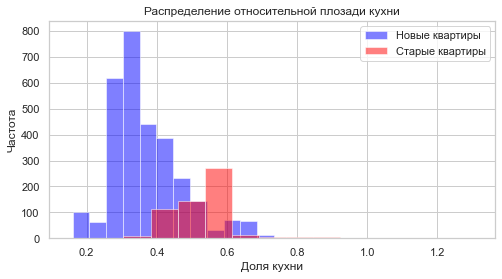

In [21]:
plt.hist(df_n['kitchen_share'], bins=15, color='blue', alpha=0.5, label='Новые квартиры')

plt.hist(df_o['kitchen_share'], bins=15, color='red', alpha=0.5, label='Старые квартиры')

plt.xlabel('Доля кухни')
plt.ylabel('Частота')
plt.title('Распределение относительной плозади кухни')
plt.legend()

plt.show()

Нормального распределения и тут нет. Снова u-тест.

In [22]:
_, p_value = sts.mannwhitneyu(df_n['kitchen_share'], df_o['kitchen_share'], alternative='less')

print("p-value:", round(p_value, 3))

p-value: 0.0


Нулевая гипотеза отвергается. Раньше кухни занималь большую площадь.

## Шаг 7: машинное обучение

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

Нашей изначальной целью работы было создание модели, которая могла бы с высокой точностью определять рыночную стоимость квартиры, поэтому зависимой переменной будет `price`. 

Для оценки качества нашей модели логичнее всего будет использовать cреднюю абсолютную процентную ошибку, MAPE, так эта метрика в контексте нашей задачи имеет наибольшее прикладное значение. 

В первую очередь надо подготовить данные:

* разбить данные на обучающую и тестовую выборку;

In [24]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

* выделить независимые и зависимый признаки;

In [25]:
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

X_test = test_df.drop(columns=['price'])
y_test = test_df['price']

* нормируем данные;

In [26]:
columns = X_train.columns

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=columns, index=X_test.index)

### Линейная регрессия ###

Сначала попробуем использовать обычную линейную регрессию.

In [27]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [28]:
y_pred = model.predict(X_test_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('MAPE: ' + str(round(mape * 100, 2)) + '%')

MAPE: 11.09%


Уже неплохо, 11% не сильно большая ошибка. Но попробуем подобрать параметры модели. 

В GridSearchCV нет встроенной функции оценки MAPE, поэтому сделаем свою.

In [29]:
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

Зададим сетку параметров.

In [30]:
param_grid = {
    'alpha': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'l1_ratio': [0.2, 0.5, 0.8],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'selection': ['cyclic', 'random'],
    'max_iter': [500, 1000, 2000, 5000],
}

In [77]:
model = ElasticNet()

grid_search = GridSearchCV(model, param_grid, scoring=scorer)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

{'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 5000, 'normalize': False, 'selection': 'random'}


In [31]:
model = ElasticNet(alpha = 0.05, fit_intercept = True, l1_ratio = 0.8, max_iter = 5000, normalize = False, selection = 'random')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('MAPE: ' + str(round(mape * 100, 2)) + '%')

MAPE: 10.05%


Немного удалось улучшить результаты линейной модели, но лучше попробовать что-то посложнее.

### Случайный лес ###

Для начала попробуем построить модель без подбора парметров.

In [32]:
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [33]:
y_pred = model.predict(X_test_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('MAPE: ' + str(round(mape * 100, 2)) + '%')

MAPE: 8.15%


~8% - отличный результат, попробуем улучшить его, подобрав параметры модели по сетке.

In [34]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [83]:
model = RandomForestRegressor()

grid_search = GridSearchCV(model, param_grid, scoring=scorer)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [35]:
model = RandomForestRegressor(max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, 
                              min_samples_split = 2, n_estimators = 500)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('MAPE: ' + str(round(mape * 100, 2)) + '%')

MAPE: 7.89%


При помощи подбора параметров по сетке удалось добиться улучшения результатов.

### Выводы ###

Итоговая средняя абсолютная процентная ошибка на уровне 7.89% - это отличный результат. Надо принимать во внимание тот факт, что данные о квартирах в действительности неполные, например, мы никак не учитываем состояние квартиры, ремонт, благоустройство дворовой территории и другие факторы, информацию о которых проблематично собрать в большом объёме.

Множно сказать, что модель хорошо подходит для быстрой и приблизительной оценки стоимости квартиры.